In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [2]:
pathImage = "matlab_teste1.jpg"
img = cv2.imread(pathImage)
# Reducing image sizes improves OpenCv's performance
height = int(img.shape[0] / 2)
width = int(img.shape[1] / 2)

In [15]:
# Main project pipeline
img_blank = np.zeros((height, width, 3), np.uint8) #Blank image

img = cv2.resize(img, (width, height))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (5, 5), 1)
img_threshold = cv2.Canny(img_blur, 100, 200)
# Let's remove some noise and make the contours thicker. This is not necessary but generates better results
img_dilated = cv2.dilate(img_threshold, np.ones((5,5)), iterations=2)
img_threshold = cv2.erode(img_dilated, np.ones((5,5)), iterations=1)

In [17]:
# Find contours
img_contours = img.copy() #For displaying
img_big_contour = img.copy() #For displaying

contours, hierarchy = cv2.findContours(img_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 10)

array([[[ 76, 112, 128],
        [ 79, 112, 131],
        [ 74, 106, 125],
        ...,
        [ 96, 136, 161],
        [ 91, 131, 156],
        [ 94, 134, 159]],

       [[ 72, 108, 126],
        [ 80, 113, 132],
        [ 81, 113, 132],
        ...,
        [ 90, 130, 155],
        [ 94, 134, 159],
        [ 93, 133, 158]],

       [[ 73, 109, 127],
        [ 80, 113, 132],
        [ 81, 113, 132],
        ...,
        [ 88, 128, 153],
        [ 95, 135, 160],
        [ 95, 135, 160]],

       ...,

       [[ 56,  90, 119],
        [ 58,  92, 121],
        [ 65,  99, 128],
        ...,
        [ 84, 124, 152],
        [ 82, 122, 150],
        [ 79, 119, 147]],

       [[ 53,  87, 116],
        [ 54,  88, 117],
        [ 66, 100, 129],
        ...,
        [ 84, 128, 152],
        [ 80, 124, 148],
        [ 82, 126, 150]],

       [[ 62,  96, 125],
        [ 56,  90, 119],
        [ 70, 104, 133],
        ...,
        [ 79, 125, 149],
        [ 78, 124, 148],
        [ 78, 124, 148]]

In [19]:
def is_rectangle(approx):
  if len(approx) == 4: # If it has 4 sides it's a rectangle
    return True
  else:
    return False

def get_biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 5000: # Minimum area to eliminate unwanted noise
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * peri, True) # Get an approximate polygon from contour shape
            if area > max_area and is_rectangle(approx):
                biggest = approx
                max_area = area
    return biggest,max_area

In [20]:
# Make sure the contours points are in order, i.e: top left is 0, top right is 1, bottom left is 2 and bottom right is 3. 
# The detection can have a different order and the rendered image would have a different orientation
def reorder(my_points):
 
    my_points = my_points.reshape((4, 2))
    my_points_ordered = np.zeros((4, 1, 2), dtype=np.int32)
    add = my_points.sum(1)
 
    my_points_ordered[0] = my_points[np.argmin(add)]
    my_points_ordered[3] = my_points[np.argmax(add)]
    diff = np.diff(my_points, axis=1)
    my_points_ordered[1] = my_points[np.argmin(diff)]
    my_points_ordered[2] = my_points[np.argmax(diff)]
 
    return my_points_ordered

In [33]:
# Find the biggest contour and transform the perpective
biggest, max_area = get_biggest_contour(contours)
if biggest.size != 0:
  biggest = reorder(biggest)
  cv2.drawContours(img_big_contour, biggest, -1, (0, 255, 0), 20) # Draw contour 'biggest' in the 'img_big_contour'
  original_points = np.float32(biggest)
  destination_points = np.float32([[0, 0], [width, 0], [0, height], [width, height]]) # We want our final points to be the edges of the image, so the image keeps it size
  transformation_matrix = cv2.getPerspectiveTransform(original_points, destination_points) # Get the transformation matrix from the image points to the destination points
  img_warp_colored = cv2.warpPerspective(img, transformation_matrix, (width, height))

In [35]:
# Remove 20 pixels from each side so even if the contour is drawn with some errors on the side we remove them
img_warp_colored = img_warp_colored[20:img_warp_colored.shape[0] - 20, 20:img_warp_colored.shape[1] - 20]
img_warp_colored = cv2.resize(img_warp_colored, (width, height))

In [36]:
# Convert our image to grayscale
img_warp_gray = cv2.cvtColor(img_warp_colored, cv2.COLOR_BGR2GRAY)

In [38]:
# Give it a more scanned look
img_adaptive_threshold = cv2.adaptiveThreshold(img_warp_gray, 255, 1, 1, 7, 2) # Get binary image
img_adaptive_threshold = cv2.bitwise_not(img_adaptive_threshold) # Reverse it, all 0 -> 1 and all 1 -> 0
img_adaptive_threshold = cv2.medianBlur(img_adaptive_threshold,3) # Reduce some noise

In [46]:
## TO STACK ALL THE IMAGES IN ONE WINDOW
def stackImages(imgArray,scale,lables=[]):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
            hor_con[x] = np.concatenate(imgArray[x])
        ver = np.vstack(hor)
        ver_con = np.concatenate(hor)
    else:
        for x in range(0, rows):
            imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        hor_con= np.concatenate(imgArray)
        ver = hor
    # if len(lables) != 0:
    #     eachImgWidth= int(ver.shape[1] / cols)
    #     eachImgHeight = int(ver.shape[0] / rows)
    #     print(eachImgHeight)
    #     for d in range(0, rows):
    #         for c in range (0,cols):
    #             cv2.rectangle(ver,(c*eachImgWidth,eachImgHeight*d),(c*eachImgWidth+len(lables[d])*13+27,30+eachImgHeight*d),(255,255,255),cv2.FILLED)
                # cv2.putText(ver,lables[d],(eachImgWidth*c+10,eachImgHeight*d+20),cv2.FONT_HERSHEY_COMPLEX,0.7,(255,0,255),2)
    return ver

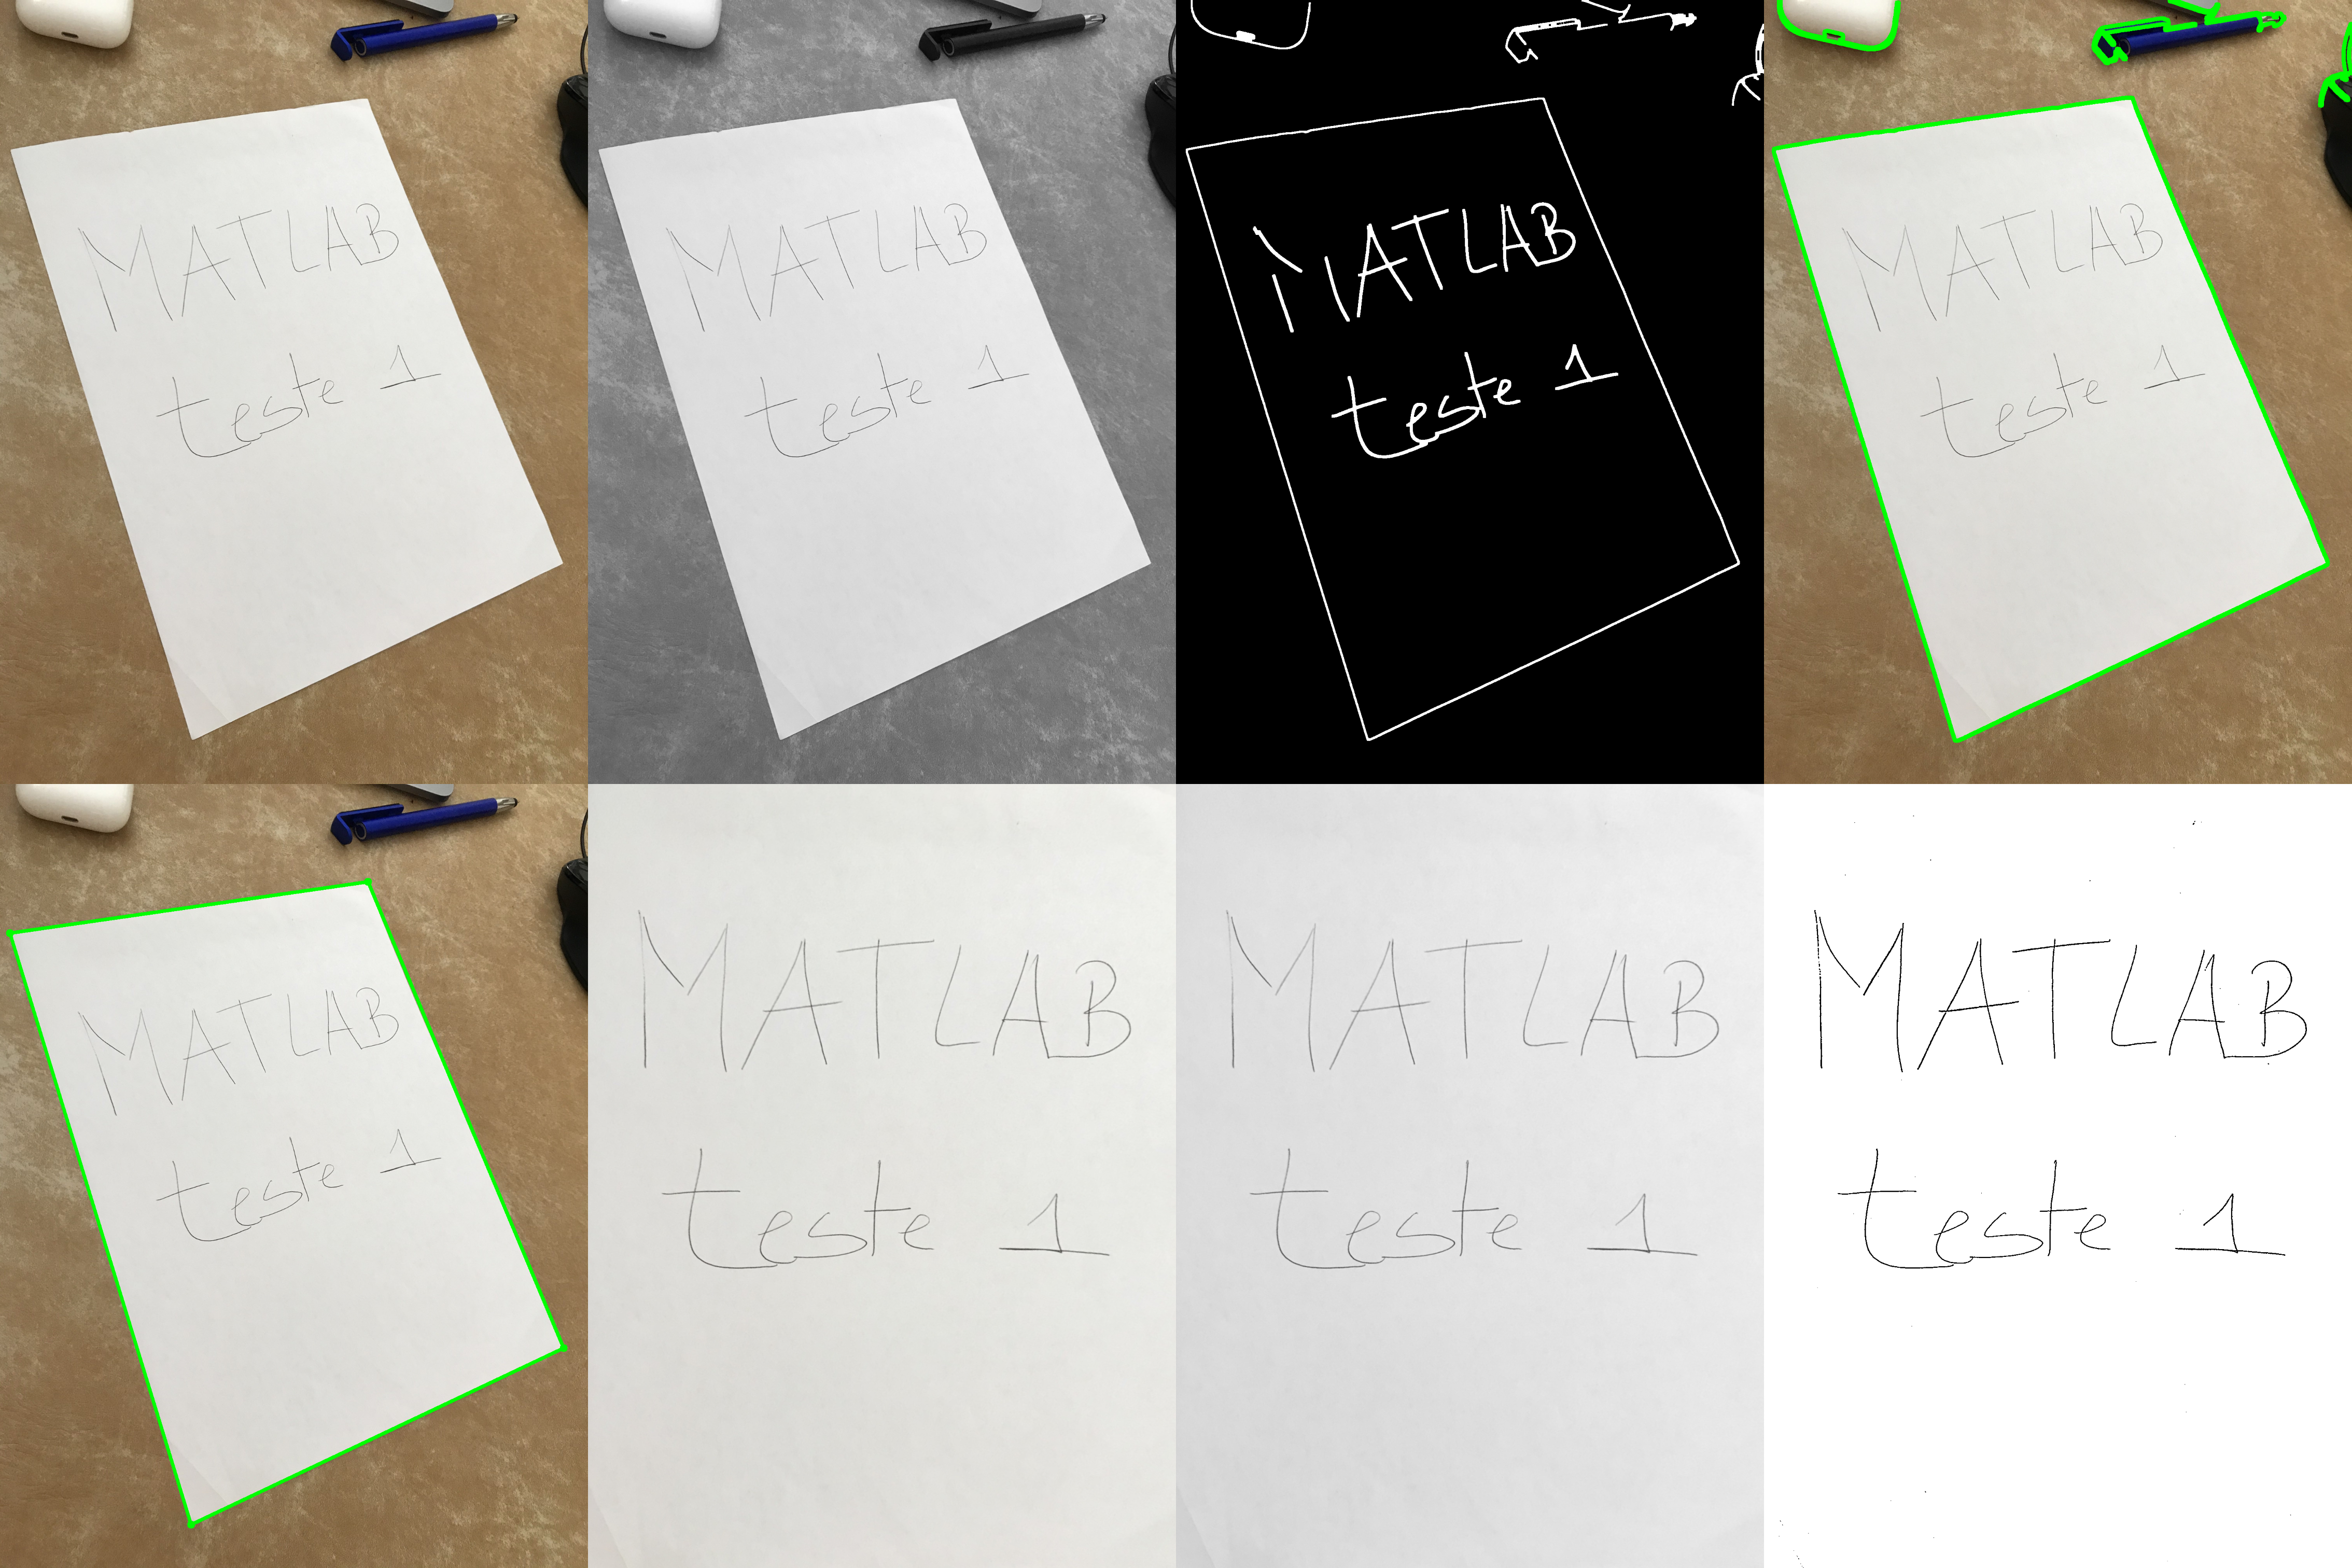

In [47]:
image_array = ([img, img_gray, img_threshold, img_contours],
               [img_big_contour, img_warp_colored, img_warp_gray, img_adaptive_threshold])
labels = [["Original", "Gray", "Threshold", "Contours"],
          ["Biggest Contour", "Warp Perpective", "Warp Grey", "Adaptive Threshold"]]

stacked_images = stackImages(image_array, 0.75, labels)
cv2_imshow(stacked_images)